### Imports and pip installs

In [249]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn

In [250]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby
from sklearn.datasets import load_breast_cancer
from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance
import numpy.typing as npt
import heapq
import time
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

## Introduction

**This laboratory work was done by Luka Konovalov and Nazar Mykhailyshchuk.**


# Task 1. Algorithm's analysis

## Generating graph

*Provided algorithm to generate connected graphs.*

In [251]:

# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

## Time measuring

### The function to measure time

In [252]:
def measure_time(algorithm, i, directed = False):
    counter = 0
    start_time = time.time()
    for _ in range(10):
        G = gnp_random_connected_graph(i, 0.7, directed, False)
        try:
            if not algorithm == bellman_ford_predecessor_and_distance:
                algorithm(G)
            else:
                bellman_ford_predecessor_and_distance(G,0)
        except Exception:
            pass
        counter += 1
    return ((time.time() - start_time) * 1000) / counter if counter > 0 else 0

NODES = [10, 20, 50, 100, 200, 500]
NODES_little = [1, 5, 10, 15, 20, 25, 35, 45, 50]

## Prim's and Kruskal's, Subtask 1.1 

Our task was to implement at least one of two algorithms(Prim's or Kruskal's) and compare them to the one's from networkx library. The Prim's and Kruskal's algorithms are used to find the MST of the graph. The graph is connected, undirected and weighted.  
We implement both of them and decided to compare them with constant completeness of 70% and rising amount of nodes(10, 20, 50, 100, 200, 500). More about it at corresponding sections.

### Kruskal's algorithm

The implementation of algorithm. Made by Luka Konovalov.

In [253]:
def find(lst:list[set], item) -> int:
    '''
    Finds the index of the set in a list of sets that contains the given item.

    Parameters:
    -----------
    lst : list[set]
        A list of sets, where each set contains elements (e.g., graph nodes).
    item : hashable
        The element to search for in the sets.

    Returns:
    --------
    int or None
        The index of the set that contains the item, or None if not found.
    '''
    index = None
    for j,i in enumerate(lst):
        if item in i:
            index = j
    return index

def kruskal_algorithm(grph):
    '''
    Implements Kruskal's algorithm to find the Minimum Spanning Tree (MST) of a 
    connected, weighted, undirected graph.

    Parameters:
    -----------
    grph : networkx.Graph
        An undirected graph where edge weights are stored under the key 'weight'.

    Returns:
    --------
    networkx.Graph
        A new graph representing the MST, containing the edges of the spanning tree.
    '''
    mst = nx.Graph()
    node_list_set = [{node} for node in grph.nodes]

    for (node1,node2,data) in sorted(grph.edges(data=True),key=lambda item: item[2]['weight']):
        first = find(node_list_set, node1)
        second = find(node_list_set,node2)
        if first != second:
            mst.add_edge(node1, node2, weight=data['weight'])
            node_list_set[first] = node_list_set[first].union(node_list_set[second])
            node_list_set.pop(second)

        if len(node_list_set) == 1:
            return mst

    return mst

Beforehand we assign a different set for each of the nodes.
So the idea behind this algorithm is that we iterate through all edges sorted in ascending order and if the nodes that this edge connects are not in the same set we add this edge to our MST and union two sets that this nodes were in. Also if there is only one set left( all node are in the same one ) we stop the iteration because we already have a MST ready.  
   
The complexity of this implementation is not efficient (around O(E log E + EV)). Usually the complexity of Kruskal algorithm is O(E log V), (V - amount of verticies; E - amount of edges), but to achieve it we would need to use Union-find data structure, which we have not enough knowledge about. So we decided to stick to something we are used to, but to suffer in efficiency.

#### **The comparison of implemetations** 

We use our function to measure time and compare the time of our and networkx implementation of Kruskal algorithm.

In [254]:
krusk_times = []
nx_times = []
for i in NODES:
    krusk_times.append(measure_time(kruskal_algorithm, i))
    nx_times.append(measure_time(nx.minimum_spanning_tree, i))

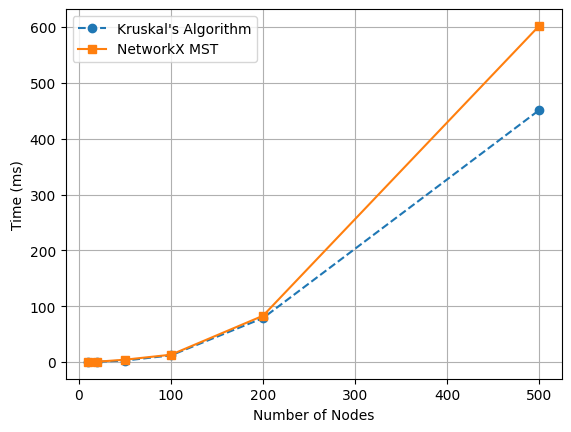

In [255]:
plt.plot(NODES, krusk_times, label="Kruskal's Algorithm", marker="o", linestyle="--")
plt.plot(NODES, nx_times, label="NetworkX MST", marker="s", linestyle="-")
plt.xlabel("Number of Nodes")
plt.ylabel("Time (ms)")
plt.legend()
plt.grid()
plt.show()

We can see that there is a slight difference between them. So our implementation is on the same level as networkx, but a bit better.

### Prim's algorithm

The implementation. Made by Nazar Mykhailyshchuk.

In [256]:
def prim(G:nx.Graph) -> tuple[nx.Graph, float]:
    '''
    def prim(G: nx.Graph):
    """
    Implements Prim's algorithm to find the Minimum Spanning Tree (MST) of a 
    connected, weighted, undirected graph.

    Parameters:
    -----------
    G : networkx.Graph
        An undirected graph where edge weights are stored under the key 'weight'.

    Returns:
    --------
    tuple:
        - res : networkx.Graph
            A new graph representing the MST, containing the edges of the spanning tree.
        - c : float
            The total weight (cost) of the MST.
    '''
    s_nd = list(G.nodes())[0]
    res = nx.Graph()
    visited = {s_nd}
    edges = [(data['weight'], s_nd, v) for v, data in G[s_nd].items()]
    heapq.heapify(edges)
    c = 0

    while len(visited) < len(G.nodes()):
        w, u, v = heapq.heappop(edges)
        if v not in visited:
            visited.add(v)
            res.add_edge(u, v, weight=w)
            c += w
            for neighbor, data in G[v].items():
                if neighbor not in visited:
                    heapq.heappush(edges, (data['weight'], v, neighbor))

    return res, c

Prim’s algorithm is a greedy approach to finding the Minimum Spanning Tree (MST) of a weighted, connected graph. The idea is simple: start from any node and keep adding the smallest edge that connects a new node to the growing tree. We use a priority queue to always pick the cheapest available edge, ensuring efficiency. The process continues until all nodes are included. The result is an MST with minimal total edge weight, and the time complexity is O(E log V) thanks to the heap operations.

#### **The comparison of implemetations** 

We use our function to measure time and compare the time of our and networkx implementation of Prim's algorithm

In [257]:
prim_times = []
nx_times = []
for i in NODES:
    prim_times.append(measure_time(prim, i))
    nx_times.append(measure_time(nx.minimum_spanning_tree, i))

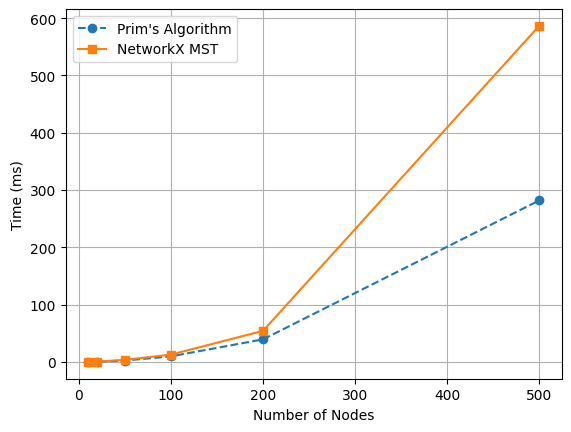

In [258]:
plt.plot(NODES, prim_times, label="Prim's Algorithm", marker="o", linestyle="--")
plt.plot(NODES, nx_times, label="NetworkX MST", marker="s", linestyle="-")
plt.xlabel("Number of Nodes")
plt.ylabel("Time (ms)")
plt.legend()
plt.grid()
plt.show()

Our implemetation take a bit less time to find the MST. It could be called a succes.

## Floyd-Worshall's and Bellman-Ford's, Subtask 1.2

Our task was to implement at least one of two algorithms(Floyd-Worshall's or Bellman-Ford's) and compare them to the one's from networkx library. The Prim's and Kruskal's algorithms are used to find the shortest route from one node(source) to all other nodes of the graph, while remembering the path. The graph is weighted, directed and connected. Important note is that these algorithms won't work if you have a cycle with negative length in the graph. It means they won't find the shortest route to all nodes, but they can detect if the graph has a negative cycle.  
We implement both of them and decided to compare them with constant completeness of 30% and rising amount of nodes(10, 20, 50, 100, 200, 500). More about it at corresponding sections.

### Bellman-Ford algorithm

The implementation. Made by Luka Konovalov.

In [259]:
def bellman_ford(weighted_graph: nx.Graph, start_node=0) -> tuple[dict | None, dict | None]:
    """
    Implements the Bellman-Ford algorithm to find the shortest paths from a 
    single source node to all other nodes in a weighted graph.

    Parameters:
    -----------
    weighted_graph : networkx.Graph or networkx.DiGraph
        A weighted graph where edge weights are stored under the key 'weight'.
    start_node : hashable, optional (default=0)
        The node from which shortest paths are calculated.

    Returns:
    --------
    tuple:
        - predecessors : dict or None
            A dictionary where each key is a node and its value is a list 
            containing the preceding node in the shortest path. If a negative 
            weight cycle is detected, returns None.
        - distances : dict or None
            A dictionary where each key is a node and its value is the shortest 
            distance from the start node. If a negative weight cycle is detected, 
            returns None.
    """
    distances = {node: float('inf') for node in weighted_graph.nodes}
    predecessors = {node: None for node in weighted_graph.nodes}

    distances[start_node] = 0
    predecessors[start_node] = []

    for iteration in range(len(weighted_graph.nodes) - 1):

        for (node_u, node_v, edge_data) in weighted_graph.edges(data=True):
            weight = edge_data['weight']
            if distances[node_v] > distances[node_u] + weight:
                distances[node_v] = distances[node_u] + weight
                predecessors[node_v] = node_u

    for (node_u, node_v, edge_data) in weighted_graph.edges(data=True):
        if distances[node_v] > distances[node_u] + edge_data['weight']:
            return None, None

    return predecessors, distances

Beforehand we create a distance dictionary and assign value to each node of infinity, also create a dict of predecessors( to remember where we came from ) and assign value of None to each node. Change the distance to source node to 0.  
The we iterate n-1 times( that's the longest path we could encounter ), inside each iteration we have a cycle through edges to update the distance dictionary(important note that when we try to get to some node from node that we haven't reached yet, so with distance ifinity, we would never assign new value because infinity is not bigger than infinity + integer). After n-1th iteration we make one more iteration to check whether the graph has negetive cycle, it works because if any value is changing on the nth iteration and there couldn't possibly be a simple path longer than n-1. And if something has changed on nth that means the is a path(cycle) with a length of n that is shorter that some other path. So the sum of all(or less than all) edges is bigger than the sum of all edges plus one, through which we can get to some point -> graph has a negative cycle.  

This implementation has a complexity of O(VE) {V - amount of verticies, E - amount of edges}, which is worse than Djkstra's(implemented with priority queue) O((V + E) log V), but if the graph is not big and has a negative edges this algorithm is suitable to use.

#### The comparison of Bellman-Ford's algorithms

We use our function to measure time and compare the time of our and networkx implementation of Bellman-Ford's algorithm

In [260]:
bellman_time = []
build_in_time = []

for i in NODES_little:
    bellman_time.append(measure_time(bellman_ford, i, True))
    build_in_time.append(measure_time(bellman_ford_predecessor_and_distance, i, True))

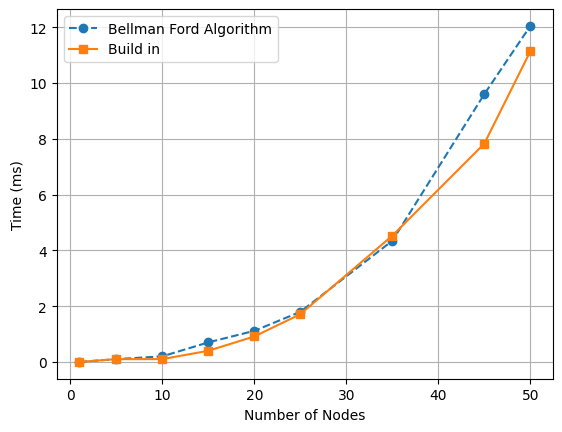

In [261]:
plt.plot(NODES_little, bellman_time, label="Bellman Ford Algorithm", marker="o", linestyle="--")
plt.plot(NODES_little, build_in_time, label="Build in", marker="s", linestyle="-")
plt.xlabel("Number of Nodes")
plt.ylabel("Time (ms)")
plt.legend()
plt.grid()
plt.show()

For small amount of nodes and 70% completeness algorithms are almost identical. Our lose slight. But with higher amount the gap would probably be o lot larger.

### Floyd-Warshall algorithm

The implementation. Made by Nazar Mykhailyshchuk.

In [262]:
def is_no_negative_cycle(t: list[list[float]]) -> bool:
    """
    Checks if the given distance matrix contains a negative cycle.

    A negative cycle is present if any diagonal element t[i][i] is negative, 
    indicating that the shortest path from a node to itself has a negative weight.

    Parameters:
    t (list[list[float]]): A square matrix representing shortest path distances 
                           between nodes in a graph.

    Returns:
    bool: True if no negative cycle is detected, False otherwise.
    """
    return all(t[i][i] >= 0 for i in range(len(t)))

def floyd_warshall(G:nx.Graph) -> dict | None:
    """
    Computes the shortest path distances between all pairs of nodes in a weighted graph 
    using the Floyd-Warshall algorithm.

    The algorithm initializes a distance matrix and iteratively updates it to find the 
    shortest paths between all node pairs. If a negative cycle is detected, the function 
    returns None.

    Parameters:
    G (networkx.Graph): A weighted directed or undirected graph where edge weights are 
                        stored in the "weight" attribute.

    Returns:
    dict or None: A nested dictionary where result[u][v] gives the shortest distance 
                  from node u to node v. If a negative cycle is detected, returns None.
    """
    nodes = list(G.nodes())
    i_map = {node: i for i, node in enumerate(nodes)}
    n = len(nodes)
    table = [[float('inf')] * n for _ in range(n)]

    for i in range(n):
        table[i][i] = 0

    for u, v, data in G.edges(data=True):
        table[i_map[u]][i_map[v]] = data["weight"]

    for k in range(n):
        for i in range(n):
            for j in range(n):
                if table[i][k] < float('inf') and table[k][j] < float('inf'):
                    table[i][j] = min(table[i][j], table[i][k] + table[k][j])

    result = {nodes[i]: {k: table[i][k] for k in sorted(nodes)} for i in sorted(nodes)}

    return result if is_no_negative_cycle(table) else None

Floyd-Warshall is an all-pairs shortest path algorithm that works by repeatedly updating a distance matrix. It starts with direct edge weights and gradually improves path estimates by considering intermediate nodes. The core idea is simple: for every possible node k, check if the path i → k → j is shorter than the direct i → j path, and update if necessary. After O(V³) iterations, we get the shortest distances between all pairs. If a negative cycle is detected (i.e., a node has a negative distance to itself), the algorithm returns None, since shortest paths wouldn’t be well-defined.

#### The comparison of Floyd-Worshall's algorithms

We use our function to measure time and compare the time of our and networkx implementation of Floyd-Worshall's algorithm

In [263]:
floyd_time = []
build_in_time = []

for i in NODES_little:
    floyd_time.append(measure_time(floyd_warshall, i, True))
    build_in_time.append(measure_time(floyd_warshall_predecessor_and_distance, i, True))

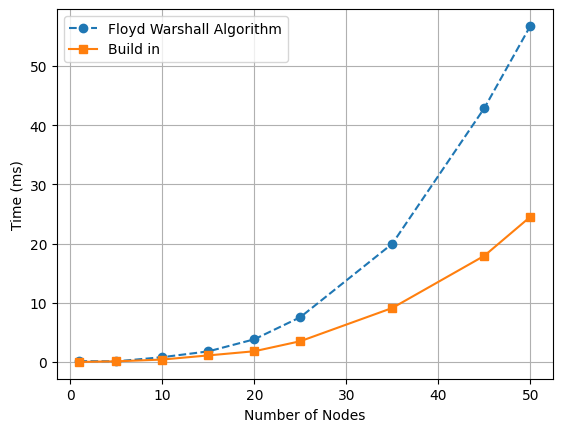

In [264]:
plt.plot(NODES_little, floyd_time, label="Floyd Warshall Algorithm", marker="o", linestyle="--")
plt.plot(NODES_little, build_in_time, label="Build in", marker="s", linestyle="-")
plt.xlabel("Number of Nodes")
plt.ylabel("Time (ms)")
plt.legend()
plt.grid()
plt.show()

The gap between them is the more, the more nodes there is. So our implementation is similar to networkx on lower amount of nodes but later lose a ton of time.

## Task 2. Decision Tree Classifier 

#### Important aspects

##### Train / test split

We train our model using training dataset and evaluate its performance basing on the test dataset. Reason to use two separate datasets is that our model learns its parameters from data, thus test set allows us to check its possibilities on completely new data.

#####  Gini impurity

Decision trees use the concept of Gini impurity to describe how “pure” a node is. A node is pure (G = 0) if all its samples belong to the same class, while a node with many samples from many different classes will have a Gini closer to 1.

$G = 1 - \sum_{k=1}^{n}p_{k}^2$

For example, if a node contains five samples, with two belonging to the first class (first flower), two of class 2, one of class 3 and none of class 4, then

$G = 1 - (\frac{2}{5})^2 - (\frac{2}{5})^2 - (\frac{1}{5})^2 = 0.64$


##### Dataset

The dataset used for this DTC is from sklearn and is about breast cancer it has 569 samples and 2 classes(0, 1). So our tree would try to determine the class(is he ill) of patient based on feature he has.

### The implementation of Decision Tree Classifier

So the main idea behind our implementation of DTC is using CART method, that include concept of gini impurity.  
About implementation itself:  
1. Node class has a lot of simple attributes let's get through them:
    - right and left stores the links to deeper node that are sons of this node.  
    - gini is the gini of the sample in the node.  
    - number_of_samples and number_of_each_type, the name tells everything.  
    - feature_ind and threshold are stored to get comparison details for later prediction.  
    - dominus_type decides what class in this node has the biggest populatio.
2. The DecisionTree class has just two simple attributes(maxdepth speaks for itself, as for gini_limit we would talk about it later). Methods:  
    - fit, practically this function does the training, but the processis in the construct_tree method  
    - getgini, calculate_information_gain and split_by_threshold speaks for themselves  
    - best_split is a very important method, a heart of decision tree, this method makes the decision by which feature and threshold of this feature to split. In our implementation we choose it by iterating through each feature index and (to optimize the construction) then by each threshold by 5% from interval( (max - min) * k, k = 0.05, 0.10. 0.15 ...) and remembers the best pair of them(using information gain and gini)
    - construct_tree build the tree based on the data(often test data) it is given using recursion and stoping if certain criateria is triggered. Here it is important to talk about gini_limit that I mentioned, before integrating it into the implementation the tree was giving very bad accuracy results for bigger depth. Some of criteria is for neccesary stop(maxdepth, gini = 0), other are made to reduce the overfitting.
    - predict just tries to get the class of item based on the features it has for every item given.  
    - evaluate just gives the accuracy of prediction



In [265]:
class Node:
    '''
    Class for Node.
    '''
    def __init__(self, gini:float, number_of_samples:int, \
        number_of_each_type:list[int]):
        '''
        The initialization of Node instance.
        '''
        self.right = None
        self.left = None
        self.gini = gini
        self.number_of_samples = number_of_samples
        self.number_of_each_type = number_of_each_type
        self.dominus_type = np.argmax(number_of_each_type)
        self.feature_idx = None
        self.threshold = None

In [266]:

class DecisionTree:
    '''
    Class for Desicion Tree.
    '''
    def __init__(self, maxdepth, gini_limit=0):
        '''
        The initialization of DecisionTree instance.
        '''
        self.maxdepth = maxdepth
        self.gini_limit = gini_limit
    def fit(self, X:npt.NDArray, Y:npt.NDArray):
        '''
        Trains the decision tree using the given dataset.

        :param X: npt.NDArray - Feature matrix.
        :param Y: npt.NDArray - Class labels.

        :param X: npt.NDArray, the training(learning) array that contains the arrays of
        features that each object has.
        :param Y: npt.NDArray, the training(learning) array that contains
        the class labels(0, 1, 2 etc..), it is connected to the X array, that
        means element with index k from y(Y[k]) has the value of features
        that are stored in X[k].
        '''
        self.tree = self.construct_tree(X, Y)
    @staticmethod
    def get_gini(Y:npt.NDArray) -> float:
        '''
        Count the gini of the Node by the array of types that it contains.

        :param Y: npt.NDArray, the array that contains
        the class labels(0, 1, 2 etc..).
        :return: float, the gini value of Node.
        '''
        _, counts = np.unique(Y, return_counts = True)
        gini = 1 - sum((amount/sum(counts))**2 for amount in counts)
        return gini
    def split_by_threshold(self, X:npt.NDArray, Y:npt.NDArray, \
                    threshold:float, feature_idx:int):
        left_indices = np.where(X[:, feature_idx] <= threshold)
        right_indices = np.where(X[:,feature_idx] > threshold)
        return X[left_indices], Y[left_indices], X[right_indices], Y[right_indices]

    def calculate_information_gain(self, Y:npt.NDArray, left_Y:npt.NDArray, right_Y:npt.NDArray) -> float:
        '''
        Calculates information gain based on the split of class array into two
        '''
        left_weight = len(left_Y) / len(Y)
        right_weight = len(right_Y) / len(Y)
        return self.get_gini(Y) - (left_weight * self.get_gini(left_Y)\
                     + right_weight * self.get_gini(right_Y))
    def best_split(self, X:npt.NDArray, Y:npt.NDArray) -> tuple[int, float]:
        '''
        Find the best possible split using gini method.

        :param X: npt.NDArray, the array that contains the arrays of
        features that each object has.
        :param Y: npt.NDArray, the array that contains
        the class labels(0, 1, 2 etc..), it is connected to the X array, that
        means element with index k from y(Y[k]) has the value of features
        that are stored in X[k].

        :return: tuple[int, float], where int represents the index of feature that we
        use to split data, whereas float if the value of that feature that we are
        splitting by
        '''
        if Y.size <= 1:
            return None, None

        best_information_gain = float('-inf')
        best_threshold = None
        best_feature_idx = None

        for feature_idx in range(X.shape[1]):
            # thresholds = np.unique(X[:, feature_idx]) was used before, but changed to 
            # optimize the algorithm
            thresholds = np.percentile(X[:, feature_idx], np.linspace(0, 100, 5))
            for threshold in thresholds:
                _, Y_extra_l, _, Y_extra_r =\
                self.split_by_threshold(X,Y,threshold, feature_idx)
                information_gain = self.calculate_information_gain(Y, Y_extra_l,Y_extra_r)
                if information_gain > best_information_gain:
                    best_information_gain = information_gain
                    best_feature_idx = feature_idx
                    best_threshold = threshold

        return best_feature_idx, best_threshold

    def construct_tree(self, X:npt.NDArray, Y:npt.NDArray, depth:int=0,):
        '''
        The construction of the tree itself, using recursion.
        '''
        node = Node(self.get_gini(Y), len(Y)\
        , np.unique(Y, return_counts = True)[1])

        if len(np.unique(Y)) == 1 or depth >= self.maxdepth or len(Y) <= 15 or node.gini <= self.gini_limit:
            return node

        if depth < self.maxdepth:
            feature_idx, threshold  = self.best_split(X, Y)
            if feature_idx is None or threshold is None:
                return node
            X_left, Y_left, X_right, Y_right = self.split_by_threshold(X, Y, threshold, feature_idx)
            if len(Y_left) == 0 or len(Y_right) == 0:
                return node
            node.threshold = threshold
            node.feature_idx = feature_idx
            node.left = self.construct_tree(X_left, Y_left, depth+1)
            node.right = self.construct_tree(X_right, Y_right, depth+1)
        return node


    def predict(self, X:npt.NDArray)->npt.NDArray:
        '''
        Predicts the objects classes by their features using decision
        tree classifier. Should be trained before using bigger portion of data,
        use fit method for that.
        '''
        return [self._predict_single(i) for i in X]

    def _predict_single(self, features):
        '''
        Predict a single object class by its features.
        '''
        node = self.tree
        while node.left or node.right:
            if node.feature_idx is None or node.threshold is None:
                return node.dominus_type
            if features[node.feature_idx] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.dominus_type

    def evaluate(self, X_test, Y_test):
        """
        Returns accuracy of the model (ratio of right guesses to the number of samples)
        """
        return np.mean(np.array(self.predict(X_test)) == Y_test)

### The testing of Decision Tree Classifier

The test will show the impact of gini_limit and maxdepth on accuracy of DTC.  
The X-axis shows Depth, the Y-axis shows accuracy, in the name of graph is the gini_limit that was set.


Following graph would show the progress of accuracy based on the gini_limit. And in the based cases our DMC give 90+ accuracy for all depth from 1 and on. So our implementatino could be called a success.

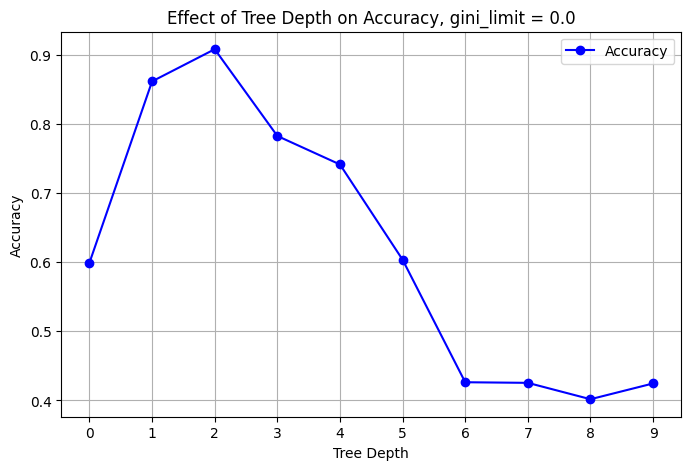

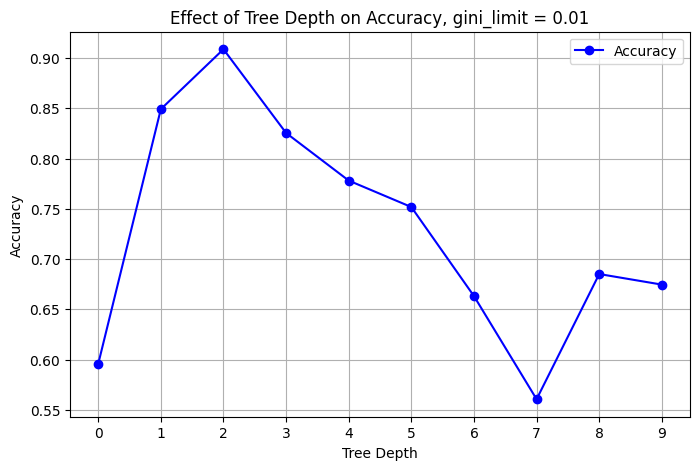

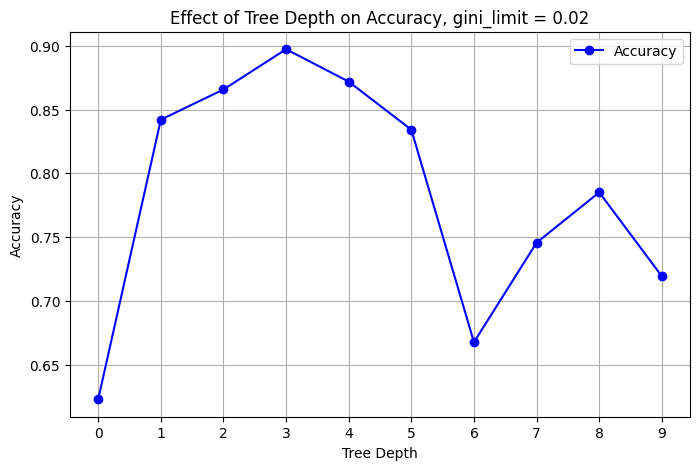

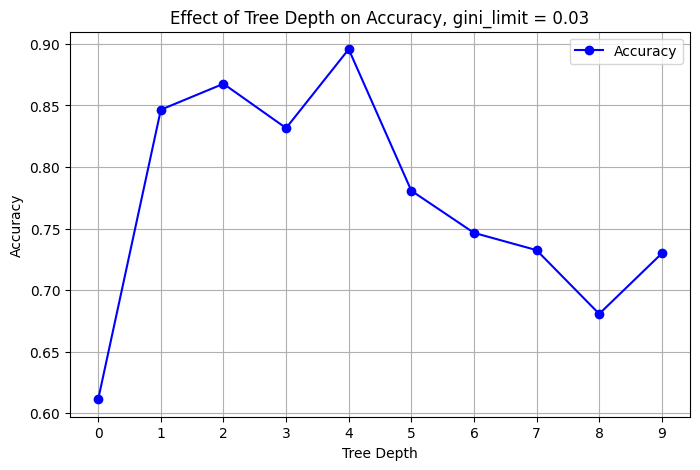

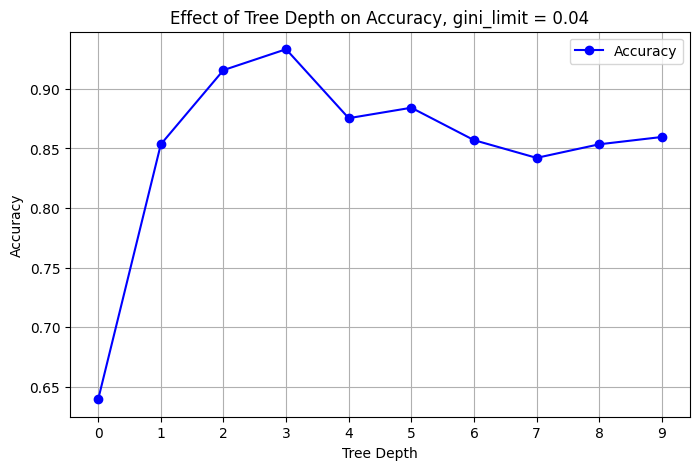

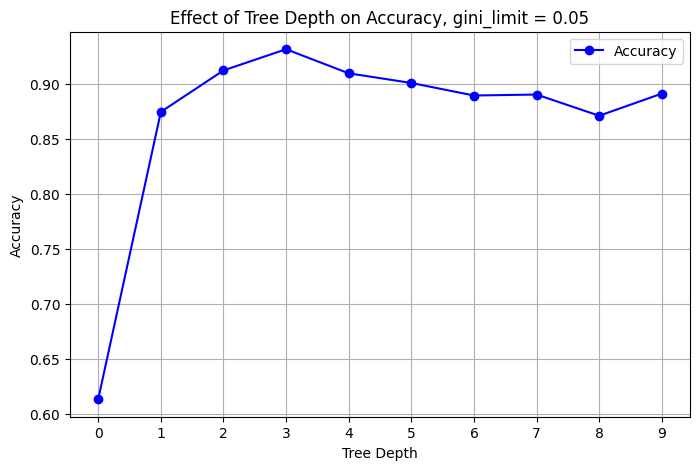

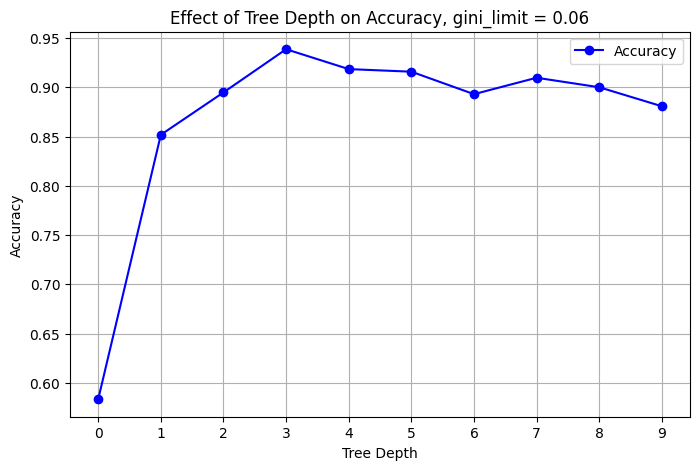

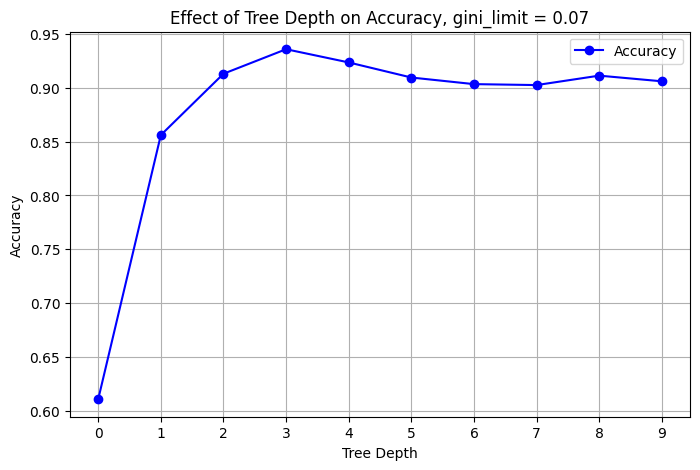

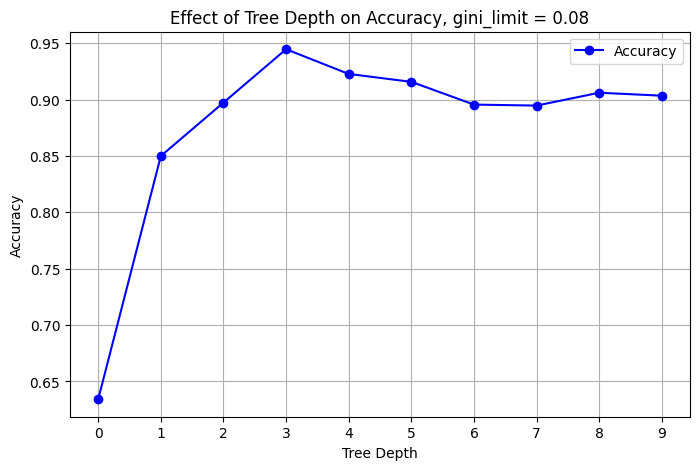

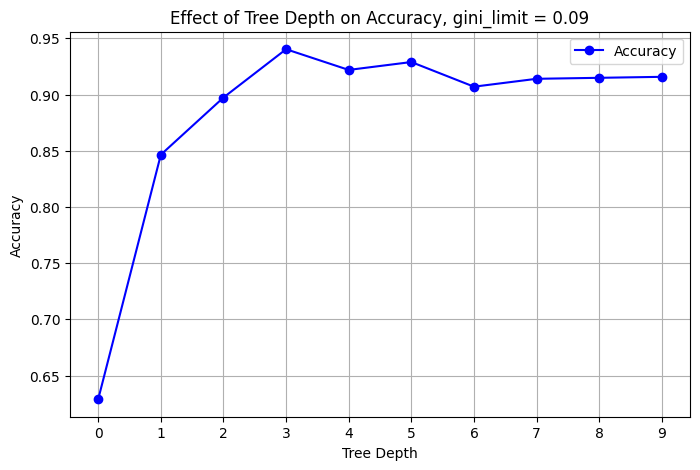

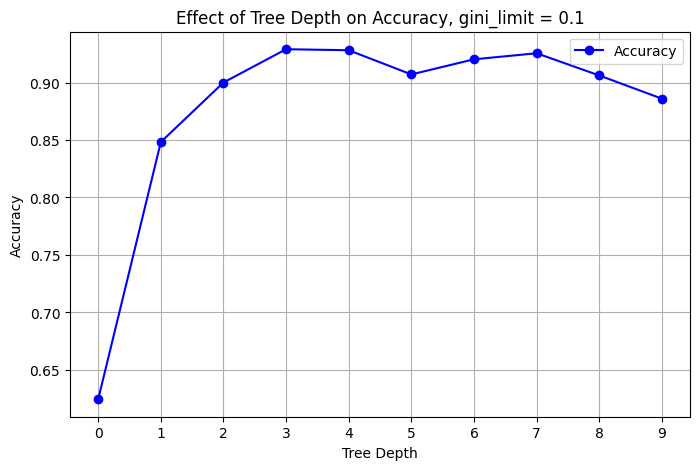

In [267]:
def test_tree(depth, gini_limit, X, y):
    clf = DecisionTree(depth, gini_limit)
    X, X_test, y, y_test = train_test_split(X, y, test_size= 0.1)
    clf.fit(X, y)
    return clf.evaluate(X_test, y_test)

dataset =  load_breast_cancer()
fea, label = dataset.data,dataset.target

dct = {}
for gini_limit in range(0, 11, 1):
    gini_limit = gini_limit * 0.01
    for depth in range(10):
        accur = np.mean(np.array([test_tree(depth, gini_limit, fea, label) for _ in range(20)]))
        dct[depth] = accur
        

    table = pd.DataFrame(list(dct.items()), columns=['Depth', 'Accuracy'])

    plt.figure(figsize=(8, 5))
    plt.plot(table['Depth'], table['Accuracy'], marker='o', linestyle='-', color='b', label='Accuracy')

    plt.xlabel('Tree Depth')
    plt.ylabel('Accuracy')
    plt.title(f'Effect of Tree Depth on Accuracy, gini_limit = {gini_limit}')
    plt.xticks(range(0, 10))
    plt.legend()
    plt.grid(True)
    plt.show()